[blog](https://aws.amazon.com/blogs/machine-learning/bringing-your-own-custom-container-image-to-amazon-sagemaker-studio-notebooks/)

In [1]:
#!pip install ipywidgets -q
#!jupyter nbextension enable --py widgetsnbextension

In [2]:
from icevision.all import *

/usr/local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
from pathlib import Path
import json

path = Path(".")

In [4]:
with open(path/ "latex_data/batch_1/JSON/kaggle_data_1.json") as f:
    data = json.load(f)    

In [5]:
class LatexParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

LatexParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


In [6]:
#data[0]["image_data"]["visible_latex_chars"]
labels = []
for o in data: labels+=o["image_data"]["visible_latex_chars"]
labels= list(set(labels))

class_map = ClassMap(labels)

In [7]:
class_map.get_name("a")

29

In [8]:
class LatexParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    
    def __init__(self, annotations_filepath, img_dir, class_map):
        self.annotations_list = json.loads(Path(annotations_filepath).read_bytes())
        self.img_dir = Path(img_dir)
        self.class_map = class_map
        
    def __iter__(self):
        yield from self.annotations_list
        
    def imageid(self, o):
        return Path(o["filename"]).stem
    
    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))
    
    def filepath(self, o):
        return self.img_dir / o["filename"]
    
    def bboxes(self, o):
        boxes = []
        for xmin, ymin, xmax, ymax in zip(o["image_data"]["xmins_raw"], o["image_data"]["ymins_raw"], o["image_data"]["xmaxs_raw"], o["image_data"]["ymaxs_raw"]):
            boxes.append(BBox.from_xyxy(xmin, ymin, xmax, ymax))
        return boxes
    
    def labels(self, o):
        return [self.class_map.get_name(label) for label in o["image_data"]["visible_latex_chars"]]

In [9]:
parser = LatexParser(path / "latex_data/batch_1/JSON/kaggle_data_1.json",
                    path/ "latex_data/batch_1/background_images",
                    class_map)
#train_rs, valid_rs = parser.parse()

In [10]:
train_rs, valid_rs = parser.parse(cache_filepath=path / "batch1.pkl")

INFO     - Loading cached records from batch1.pkl | icevision.parsers.parser:parse:114


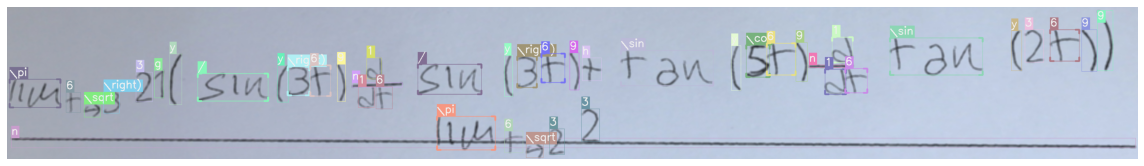

In [11]:
show_records(train_rs[:1], ncols=1, class_map=class_map, figsize=(16,7))

In [12]:
from PIL import Image
im = Image.open(train_rs[0]["filepath"])
im.size

(3186, 429)

In [13]:
presize = 1280
# For EffecientDet the size of the image has to be divisible by 128
size = 1024
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize, shift_scale_rotate=None, crop_fn=None), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

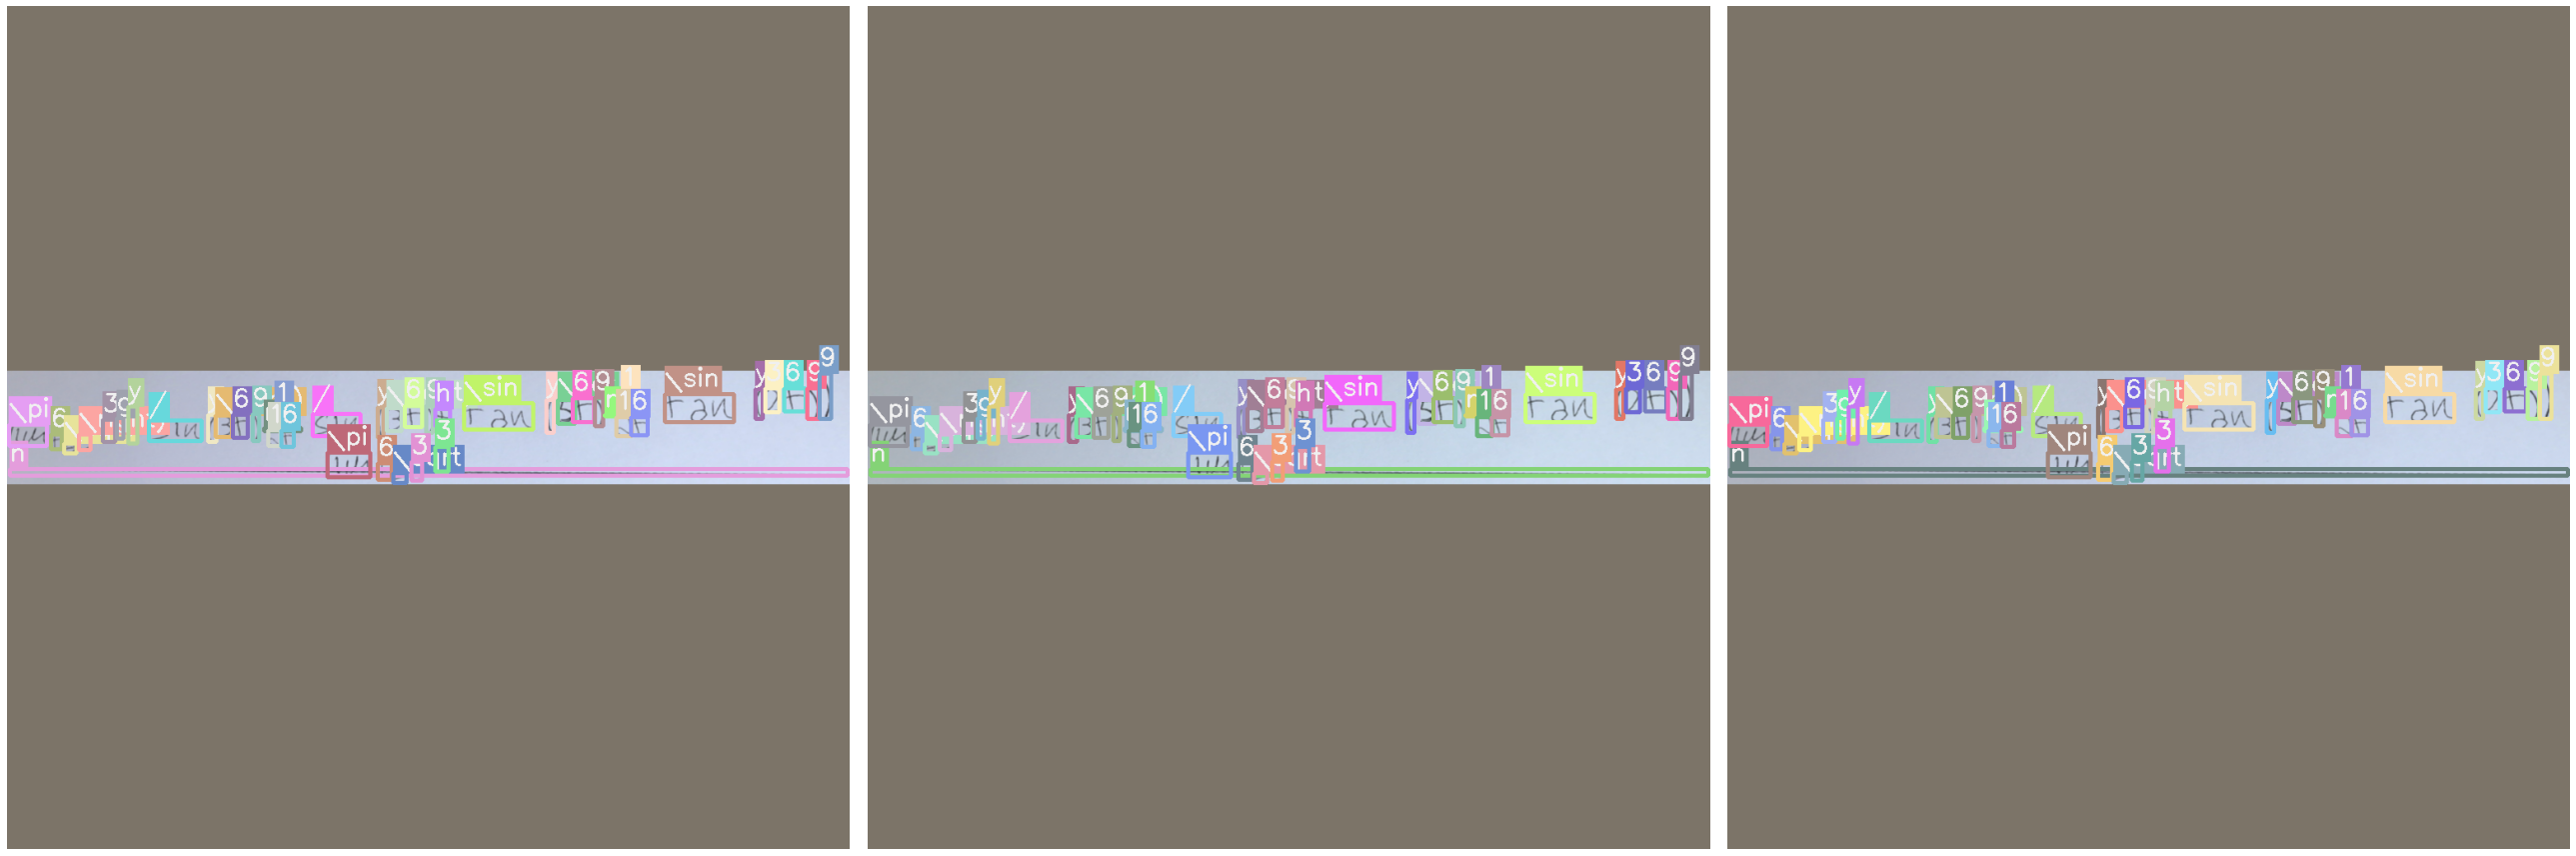

In [14]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=class_map, denormalize_fn=denormalize_imagenet)

In [15]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=8, num_workers=0, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=8, num_workers=0, shuffle=False)

In [16]:
#model = efficientdet.model(model_name="tf_efficientdet_lite0", num_classes=len(class_map), img_size=size)
model = faster_rcnn.model(num_classes=len(class_map))

# Define metrics
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

# Fastai Learner
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [17]:
train_rs[0]

Record:
	- Image ID: 3782
	- Image size (width, height): (3186, 429)
	- Filepath: latex_data/batch_1/background_images/e3deeb5a-518a-473a-8b94-662f94e57157.jpg
	- Labels: [13, 51, 53, 7, 24, 12, 1, 18, 41, 18, 24, 53, 26, 13, 22, 22, 53, 41, 18, 24, 53, 26, 37, 5, 18, 19, 53, 26, 13, 22, 22, 53, 5, 18, 12, 53, 26, 26, 51, 53, 7, 12, 12]
	- BBoxes: [<BBox (xmin:12, ymin:370, xmax:3179, ymax:397)>, <BBox (xmin:7, ymin:205, xmax:150, ymax:284)>, <BBox (xmin:166, ymin:242, xmax:207, ymax:298)>, <BBox (xmin:217, ymin:275, xmax:262, ymax:311)>, <BBox (xmin:272, ymin:240, xmax:316, ymax:300)>, <BBox (xmin:363, ymin:185, xmax:409, ymax:268)>, <BBox (xmin:415, ymin:180, xmax:441, ymax:257)>, <BBox (xmin:458, ymin:134, xmax:492, ymax:276)>, <BBox (xmin:537, ymin:189, xmax:735, ymax:266)>, <BBox (xmin:762, ymin:166, xmax:793, ymax:269)>, <BBox (xmin:790, ymin:170, xmax:851, ymax:250)>, <BBox (xmin:854, ymin:166, xmax:911, ymax:252)>, <BBox (xmin:930, ymin:163, xmax:953, ymax:267)>, <BBox (xmin:97

In [18]:
# Fastai Training
#learn.freeze()
#learn.lr_find()

In [19]:
learn.fine_tune(10, lr=2e-3, freeze_epochs=3)

KeyboardInterrupt: 